In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from scipy.optimize import differential_evolution
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Определение начальных параметров
maxCorners = 8
img_size = 28
pop_size = 10
epo_num = 30
max_iter = 10

In [3]:
def harris_corner_detector(image):
    '''
    Функция обнаужения углов на изоюражении с помощью алгоримта Харриса(не самый идеальный поиск углов!!!)
    :param image: входящее мзображение
    :return: массив координат углов
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.goodFeaturesToTrack(gray, maxCorners, qualityLevel=0.01, minDistance=5)
    # Возвращаем координаты углов
    return corners

In [ ]:
def harris_corner_detector_checker(img):
    """
    Фукция проверки работы алгоритма поиска углов Харриса
    :param img: вхрдящее изображение
    :return: отображение картинки с отрисованными углами
    """

    # Создаем копию исходного изображения, чтобы нарисовать на нем углы
    img_corners = img.copy()

    corners = harris_corner_detector(img)
    # Отмечаем углы на копии изображения
    for corner in corners:
        x, y = corner.ravel()
        cv2.circle(img_corners, (int(x), int(y)), 5, (0, 0, 255), 2)

    # Объединение изображений горизонтально
    output_img = cv2.hconcat([img, img_corners])

    # Отображение изображения до и после обработки
    cv2.imshow('Original Image vs. Harris Corners', output_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# harris_corner_detector_checker(cv2.imread('18.png'))

In [5]:
def load_set(path):
    """
    Загрузка датасета и его обработка
    :param path: путь к датасету
    :return: массив изобраджении и координат
    """
    x, y = [], []
    max_corners = 0
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (img_size, img_size))  # изменение размера изображения
            corners = harris_corner_detector(image)  # получение углов изображения
            corners = corners.reshape(-1, 2)
            x.append(image)
            y.append(corners)
            if len(corners) > max_corners:
                max_corners = len(corners)

    # Преобразование коротких массивов до длинных
    for i in range(len(y)):
        num_corners = len(y[i])
        if num_corners < max_corners:
            padding = np.zeros((max_corners - num_corners, 2))
            y[i] = np.concatenate([y[i], padding])

    x = np.array(x)
    y = np.array(y)
    return x, y

In [6]:
def split_dataset(x, y):
    """
    Разделение датасета на обучающую и тестовую выборки в отношении 80/20
    :param x: набор картинок
    :param y: набор координат углов
    :return:
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

In [7]:
def define_model(num_neurons_1, dropout_1):
    """
    Определение нейросети
    :param num_neurons_1: количесвто нейроннов последенго уровня
    :param dropout_1: Параметр выхода из обучения
    :return: модель нейронной сети
    """
    # Создание модели нейронной сети
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=(img_size, img_size, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_neurons_1, activation='relu'),
        tf.keras.layers.Dropout(dropout_1),
        tf.keras.layers.Dense(maxCorners*2, activation="softmax"),
    ])
    return model

In [8]:
class Individual_Digits:
    """
    Определяет индивиидума
    """

    def __init__(self, params):
        """
        Конструктор класса, полчение параметров
        :param params:
        """
        self.parameters = copy.deepcopy(params)
        self.history = None

    def init_current(self, r_state):
        """
        Принимает объект генератора случайных чисел и инициализирует начальные значения для каждого параметра
        индивиидума, используя методы случайной генерации из модуля numpy
        :param r_state: генератор случайных чисел
        :return:
        """
        next_state = 0
        for par in self.parameters.keys():
            state = r_state + next_state
            if self.parameters[par]["val_range"].dtype == int:
                self.parameters[par]["current"] = np.random.RandomState(state).randint(
                    low=self.parameters[par]["val_range"][0],
                    high=self.parameters[par]["val_range"][1])
            else:
                self.parameters[par]["current"] = np.random.RandomState(state).uniform(
                    low=self.parameters[par]["val_range"][0],
                    high=self.parameters[par]["val_range"][1])
            next_state += 1

    def build_model(self):
        """
        Создает нейронную сеть на основе параметров индивидуума, заданных в параметрах.
        :return:
        """
        model = define_model(num_neurons_1=self.parameters["num_neurons_1"]["current"],
                             dropout_1=self.parameters["dropout_1"]["current"])
        return model

    def train(self, x_train, y_train, x_test, y_test, verbose=0):
        """
         Обучает нейронную сеть и оценивает результаты. Он использует метод compile, чтобы сконфигурировать модель с
         функцией потерь MSE и оптимизатором ADAM, а также метод fit для обучения модели. После обучения модели
         результаты оцениваются с помощью метода evaluate, и значения accuracy и loss сохраняются в переменные
         self.score и self.loss соответственно. В конце метода модель удаляется.
        :param x_train: обучающий набор входных данных
        :param y_train: обучающий набор меток
        :param x_test: тестирующий набор входных данных
        :param y_test: тестирующий набор меток
        :param verbose: уровень детализации
        :return:
        """
        model = self.build_model()
        # model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #               optimizer=tf.keras.optimizers.Adam(learning_rate=self.parameters["lr"]["current"]),
        #               metrics=["accuracy"])
        model.compile(loss='mse',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=self.parameters["lr"]["current"]),
                      metrics=["accuracy"])

        self.history = model.fit(x_train, y_train,
                                 batch_size=16 * self.parameters["batchsize"]["current"],
                                 epochs=epo_num,
                                 verbose=verbose,
                                 workers=4)
        dev_loss, dev_acc = model.evaluate(x_test, y_test)
        self.score = dev_acc
        self.loss = dev_loss
        del model

In [19]:
# Загрузка и подготовка данных
path = 'FourShapesDataset/archive/shapes/1'
x, y = load_set(path)
x_train, x_test, y_train, y_test = split_dataset(x, y)

# Нормализация данных
x_train = x_train / 255.0
x_test = x_test / 255.0
# Нормализация данных
y_train = y_train / img_size
y_test = y_test / img_size

# изменить размерность y_true
razm = y_train.shape[1] * y_train.shape[2]
y_train = y_train.reshape((-1, maxCorners*2))
y_test = y_test.reshape((-1, maxCorners*2))

# Инициализация параметров
parameters = {
    "dropout_1": {"val_range": np.array([0.1, 0.9]).astype(float), "current": None},
    "num_neurons_1": {"val_range": np.array([10, 300]).astype(int), "current": None},
    "lr": {"val_range": np.array([0.005, 0.01]).astype(float), "current": None},
    "batchsize": {"val_range": np.array([4, 8]).astype(int), "current": None}
}

# Создание индивиидума нейронной сети
individual = Individual_Digits(parameters)
# Инициализация индивиидума
individual.init_current(2)
# Вывод рандомных параметров индивиидума
for par in individual.parameters.keys():
    print("Par {}, {}".format(par, individual.parameters[par]["current"]))
# Обучение
individual.train(x_train, y_train, x_test, y_test, verbose=1)
# Расчет точности обучения
score = individual.score
print(score)

Par dropout_1, 0.44879592171360305
Par num_neurons_1, 162
Par lr, 0.009835149195068383
Par batchsize, 7
Epoch 1/30
107/107 [==============================] - 4s 28ms/step - loss: 0.1551 - accuracy: 0.1657
Epoch 2/30
107/107 [==============================] - 3s 29ms/step - loss: 0.1538 - accuracy: 0.1805
Epoch 3/30
107/107 [==============================] - 3s 28ms/step - loss: 0.1534 - accuracy: 0.1698
Epoch 4/30
107/107 [==============================] - 3s 29ms/step - loss: 0.1531 - accuracy: 0.1787
Epoch 5/30
107/107 [==============================] - 3s 28ms/step - loss: 0.1530 - accuracy: 0.1792
Epoch 6/30
107/107 [==============================] - 3s 28ms/step - loss: 0.1528 - accuracy: 0.1720
Epoch 7/30
107/107 [==============================] - 3s 28ms/step - loss: 0.1527 - accuracy: 0.1802
Epoch 8/30
107/107 [==============================] - 3s 29ms/step - loss: 0.1526 - accuracy: 0.1817
Epoch 9/30
107/107 [==============================] - 3s 28ms/step - loss: 0.1526 - accu

In [10]:
class DE_NeuralNets():
    """
    Алгоритм Differential Evolution для оптимизации гиперпараметров нейронной сети на задаче распознавания углов
    """

    def __init__(self,
                 scaling_rate=0.5,
                 crossover_rate=0.5,
                 population_size=pop_size,
                 max_generation_steps=max_iter):
        """
        Конструктор класса, иницаилизация гиперпараметров оптимизации, загрузка и обработка  тренировочных и тестовых данных
        :param scaling_rate:
        :param crossover_rate:
        :param population_size: размер популяции
        :param max_generation_steps: максимальное количество итерации для одного поколения
        """
        self.scaling_rate = scaling_rate
        self.crossover_rate = crossover_rate
        self.population_size = population_size

        self.generation_counter = 0

        self.all_generations = []
        self.max_generation_steps = max_generation_steps

        # Загрузка данных
        path = 'FourShapesDataset/archive/shapes/1'
        x, y = load_set(path)
        x_train, x_test, y_train, y_test = split_dataset(x, y)

        # Нормализация данных
        x_train = x_train / 255.0
        x_test = x_test / 255.0
        # Нормализация данных
        y_train = y_train / img_size
        y_test = y_test / img_size

        # Изменить размерность y_true
        y_train = y_train.reshape((-1, maxCorners*2))
        y_test = y_test.reshape((-1, maxCorners*2))

        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def init_generation(self):
        """
        Инизиализация первого поколения популяции
        :return:
        """
        self.generation = []
        self.generation_costs = []
        for i in range(self.population_size):
            individual = Individual_Digits(self.parameters)
            random_state = i * len(self.parameters)
            individual.init_current(random_state)
            individual.train(x_train=self.x_train,
                             y_train=self.y_train,
                             x_test=self.x_test,
                             y_test=self.y_test,
                             verbose=1)
            self.generation_costs.append(individual.score)
            self.generation.append(individual)

    def add_params(self, params):
        """
        Полечение гиперпарамаетров
        :param params: входящие параматеры
        :return: опредление параметров
        """
        for par in params.keys():
            val_range = params[par]["val_range"]
            if not isinstance(val_range, np.ndarray):
                raise TypeError("The value range must be of type list.")
            if len(val_range) != 2:
                pass
            if val_range[0] > val_range[1]:
                pass
        self.parameters = params

    def check_boundaries(self, mutation, low_bound, high_bound):
        """
        Проверка границ
        :param mutation: параметры мутанта
        :param low_bound: нижняя граница
        :param high_bound: верхняя граница
        :return: изменные параметры мутанта
        """
        if mutation < low_bound:
            mutation = low_bound
        elif mutation > high_bound:
            mutation = high_bound
        return mutation

    def get_candidates(self, i):
        """
        Выбор кандидата дял мутации
        :param i: номер поколения
        :return: выбранный кандидат
        """
        to_select = list(np.arange(self.population_size))
        to_select.remove(i)
        candidates = np.random.choice(to_select, 3, replace=False)
        return candidates

    def mutate(self, i):
        """
        Мутация популяции, выбирая случайным образом трех кандидатов из текущего поколения и создавая мутировавшего
        индивидуума, изменяя его гиперпараметры по формуле
        :param i: номер поколения
        :return: мутант
        """
        candidates = self.get_candidates(i)
        mutant = Individual_Digits(self.generation[candidates[0]].parameters.copy())
        for par in self.parameters.keys():
            A = self.generation[candidates[1]].parameters[par]["current"]
            B = self.generation[candidates[2]].parameters[par]["current"]
            if type(A) is float:
                mutation = mutant.parameters[par]["current"] + self.scaling_rate * (A - B)
            else:
                mutation = mutant.parameters[par]["current"] + int(np.round(self.scaling_rate * (A - B)))
            mutation = self.check_boundaries(mutation,
                                             mutant.parameters[par]["val_range"][0],
                                             mutant.parameters[par]["val_range"][1])
            mutant.parameters[par]["current"] = mutation
        return mutant

    def crossover(self, mutant, target):
        """
        Cкрещивание двух индивидуумов (мутировавшего и целевого) и создает потомка, на основе которого будет
        проводиться следующая итерация оптимизации
        :param mutant: мутант
        :param target: целевой
        :return: список для оптимизации
        """
        param_list = list(self.parameters.keys())
        random_par = np.random.choice(param_list)
        trial = Individual_Digits(target.parameters.copy())
        for par in param_list:
            crossover_unit = np.random.uniform(0, 1)
            if crossover_unit <= self.crossover_rate or par == random_par:
                trial.parameters[par]["current"] = mutant.parameters[par]["current"]
        return trial

    def get_trials(self):
        """
        Проведение обучения с мутировавшим и его потомком
        :return:
        """
        print("-- Trials are computed --")
        self.trials = []
        self.trials_costs = []
        for i in range(self.population_size):
            target = self.generation[i]
            mutant = self.mutate(i)
            trial = self.crossover(mutant, target)
            trial.train(x_train=self.x_train,
                        y_train=self.y_train,
                        x_test=self.x_test,
                        y_test=self.y_test,
                        verbose=0)
            self.trials_costs.append(trial.score)
            self.trials.append(trial)

    def select(self):
        """
        Выбор лучшего индивидуума
        :return:
        """

        fusion = self.trials_costs[:]
        fusion.extend(self.generation_costs[:])
        candidate_pool = self.trials[:]
        candidate_pool.extend(self.generation[:])

        idx = np.argsort(np.array(fusion))[::-1]

        # выбор лучшего индивиидума из двух (generation & trials)
        for i in range(len(self.generation)):
            self.generation[i] = candidate_pool[idx[i]]
            self.generation_costs[i] = fusion[idx[i]]

    def evolve(self):
        """
        Проведение самой эволюции
        :return:
        """
        self.best_solutions = []
        self.worst_solutions = []
        self.init_generation()
        self.all_generations.append(self.generation[:])
        while (self.generation_counter < self.max_generation_steps):
            self.get_trials()
            self.select()
            self.all_generations.append(self.generation[:])
            self.generation_counter += 1
            self.best_solutions.append(np.max(self.generation_costs))
            self.worst_solutions.append(np.min(self.generation_costs))

In [11]:
# Запуска процесса оптимизации на основе DE
print("Start of evolve process:")
eve = DE_NeuralNets()
eve.add_params(parameters)
evolve_res = eve.evolve()
print(evolve_res)

Start of evolve process:
Epoch 1/30
125/125 [==============================] - 4s 25ms/step - loss: 0.1557 - accuracy: 0.1524
Epoch 2/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1541 - accuracy: 0.1908
Epoch 3/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1540 - accuracy: 0.1939
Epoch 4/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1539 - accuracy: 0.1946
Epoch 5/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1537 - accuracy: 0.1880
Epoch 6/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1537 - accuracy: 0.1966
Epoch 7/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1536 - accuracy: 0.2034
Epoch 8/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1535 - accuracy: 0.2077
Epoch 9/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1535 - accuracy: 0.2039
Epoch 10/30
125/125 [==============================] - 3s 23ms/ste

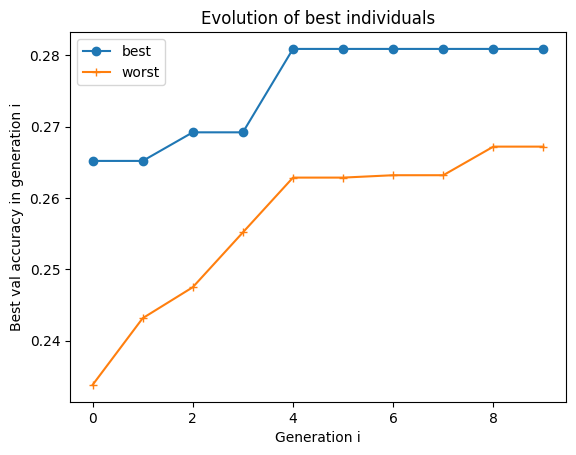

In [12]:
# отрисовка графика (только для jupyter-lab и прописанного %matplotlib inline)
plt.plot(eve.best_solutions, 'o-', label="best")
plt.plot(eve.worst_solutions, '+-', label="worst")
plt.ylabel("Best accuracy in generation i")
plt.xlabel("Generation i")
plt.title("Evolution of best individuals")
plt.legend()